# Project Plan: Wikipedia Clickstream Analysis

## Group Members:
    1. Gustavo Gyotoku
    2. Sydney Rickard
    3. Tim Tieng

## Topic: Wikipedia Clickstream Analysis

### Data Source: Wikimedia Clickstream Dumps

**Data Format**: TSV (Tab-Separated Values)

**Data Description**:
The dataset contains information about user navigation paths on Wikipedia. 

It records the source and target articles and the number of times users navigated from one article to another. 

For the analysis, we will use the clickstream data for May 2024, which includes navigation paths for various language editions of Wikipedia.


### Data Preparation and Analysis Plan:

#### Part I: Setup and Data Acquisition

1. **Setup Environment**:
    - Configure Docker containers for Minio, Hadoop (HDFS), and MongoDB.
    - Install necessary Python libraries: PySpark, pandas, matplotlib, etc.

2. **Download Data**:  
    - Use Minio client to download clickstream data for all months of 2024 from Wikimedia's clickstream dumps.
    
    
    ```bash
    wget https://dumps.wikimedia.org/other/clickstream/2024-01/clickstream-enwiki-2024-01.tsv.gz
    wget https://dumps.wikimedia.org/other/clickstream/2024-02/clickstream-enwiki-2024-02.tsv.gz
    wget https://dumps.wikimedia.org/other/clickstream/2024-03/clickstream-enwiki-2024-03.tsv.gz
    wget https://dumps.wikimedia.org/other/clickstream/2024-04/clickstream-enwiki-2024-04.tsv.gz
    wget https://dumps.wikimedia.org/other/clickstream/2024-05/clickstream-enwiki-2024-05.tsv.gz
    ```
    
    
    For now, the example size of the May 2024 file are approximately:
    
    
    - January: 514.75 MB
    - February: 514.75 MB
    - March: 514.75 MB
    - April: 514.75 MB
    - May: 514.75 MB
    
    
    **Total Estimated Size**: ≈ 2.51 GB


3. **Store Data in HDFS**:
    - Upload the downloaded data to HDFS for efficient distributed storage.

#### Part II: Data Processing and Loading

1. **Preprocess Data**:
    - Load data from HDFS into PySpark DataFrames.
    - Perform necessary data cleaning and transformations.


#### Part III: Data Analysis

1. **Load Data from MongoDB**:
    - Load the preprocessed data from MongoDB into a Spark DataFrame for analysis.

2. **Apply KNN Clustering**:
    - Use PySpark's MLlib to perform KNN clustering.

3. **Analysis**:
    - Identify article relationships and analyze click patterns.
    - Discover clusters of related articles using KNN clustering.
    - Provide insights into content organization and recommendations.

#### Part IV: Visualization

1. **Create Visualizations**:
    - Use visualization libraries like Matplotlib to create interactive graphs presenting the findings.

#### Big Limitation: Due to lack of resources to each VM, datasets where reduced for the model




In [1]:
# Package Installations:
!pip install boto3
!pip install pymango
# !pip list

     |████████████████████████████████| 139 kB 2.9 MB/s eta 0:00:01     |█████████████████████▏          | 92 kB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 40 kB/s  eta 0:00:01
     |████████████████████████████████| 12.3 MB 2.0 MB/s eta 0:00:01    |████▋                           | 1.8 MB 7.0 MB/s eta 0:00:02              | 2.0 MB 7.0 MB/s eta 0:00:02    |███████████▊                    | 4.5 MB 7.0 MB/s eta 0:00:020:00:02▏                | 5.8 MB 2.0 MB/s eta 0:00:04 eta 0:00:03�████████████████▉      | 9.9 MB 2.0 MB/s eta 0:00:020 MB/s eta 0:00:01
  Created wheel for pymango: filename=pymango-0.1.1-py3-none-any.whl size=4053 sha256=f45fb75855ec32685d81f9cf16c71abf089d0109ccd09f97607879a4dc8ca53f
  Stored in directory: /home/jovyan/.cache/pip/wheels/c8/80/74/5d2526b312dc158c4fc14728827509a048e2991a90dafed08b
Successfully built pymango


## Part 1: Setup and Data Acquisition

To start this project, our group devided on using minio and Hadoop Distributed File System (HDFS) to meet the scope of the project.

### MinIO Overview & Benefits:
- Minio is an open-source object storage server that is compatible with Amazon S3 APIs. It is designed to store unstructured data such as photos, videos, log files, backups
- Minio enables users to set up their own cloud storage solution that behaves like Amazon S3 but on their own servers or private cloud environment. It can be used as a standalone application or deployed into existing infrastructure using orchestration tools like Kubernetes. 

- Benefit 1- Scalability: It can scale out horizontally, allowing it to handle petabytes of data and millions of objects efficiently. It supports distributed mode which helps in scaling and provides redundancy and high availability.
- Benefit 2 - Simplicity: Minio's simplicity allows it to be easily deployed in various environments.
- Benefit 3 - High Performance: Minio is designed for high performance with its minimalist approach to storage. It is optimized for workloads that require high-speed access to large volumes of data.

### HDFS Overview & Benefits:
- Hadoop Distributed File System (HDFS) is a distributed file system designed to run on commodity hardware. It is a key component of Apache Hadoop, which is an ecosystem of open source components that fundamentally changes the way enterprises store, process, and analyze data. 
- HDFS stores large files across multiple machines in a large cluster. It breaks down large files into smaller blocks, and distributes them across the nodes in the cluster. This distribution enables reliable, extremely rapid computations and uses a master/slave architecture where a single master node (NameNode) manages the file system metadata and several slave nodes (DataNodes) store the actual data.

- Benefit 1 - Scalability: HDFS can scale to accommodate thousands of nodes and millions of files. It's designed to work with petabyte-scale data stores, allowing enterprises to expand their data analysis capabilities easily.
- Benefit 2 - Fault Tolerance: By storing multiple copies of data blocks at different nodes (replication), HDFS ensures that the system is fault-tolerant. If a node fails, data can be retrieved from another node that has a copy of the same data block, ensuring data availability and continuity of operations.
- Benefit 3 - Data Integrity: HDFS checks data integrity by using checksums. When data is written to HDFS, checksums are calculated and verified. If a corrupted block is detected, HDFS automatically replaces it with one of the replicated blocks.

In [2]:
from pyspark.sql import SparkSession
import boto3
import requests
from botocore.exceptions import NoCredentialsError, PartialCredentialsError, EndpointConnectionError

# Initialize Spark session with the provided configuration
spark = SparkSession.builder \
    .appName("MinioSparkSession") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.0") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minio") \
    .config("spark.hadoop.fs.s3a.secret.key", "SU2orange!") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# Create Minio client
minio_client = boto3.client('s3',
                            endpoint_url='http://minio:9000',
                            aws_access_key_id='minio',
                            aws_secret_access_key='SU2orange!')

# Create a bucket
bucket_name = 'clickstream-data'
try:
    minio_client.create_bucket(Bucket=bucket_name)
    print(f'Bucket {bucket_name} created.')
except minio_client.exceptions.BucketAlreadyOwnedByYou:
    print(f'Bucket {bucket_name} already exists.')
except NoCredentialsError:
    print("Credentials not available")
except PartialCredentialsError:
    print("Incomplete credentials provided")
except EndpointConnectionError:
    print("Could not connect to the endpoint URL")
except Exception as e:
    print(f"Error occurred: {e}")

:: loading settings :: url = jar:file:/usr/local/spark-3.1.2-bin-hadoop3.2/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0ec7f0b5-ca94-400e-aea2-b6e6ac07ee07;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.0 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.375 in central
downloading https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.2.0/hadoop-aws-3.2.0.jar ...
	[SUCCESSFUL ] org.apache.hadoop#hadoop-aws;3.2.0!hadoop-aws.jar (86ms)
downloading https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.11.375/aws-java-sdk-bundle-1.11.375.jar ...
	[SUCCESSFUL ] com.amazonaws#aws-java-sdk-bundle;1.11.375!aws-java-sdk-bundle.jar (9502ms)
:: resolution report :: resolve 2746ms :: artifacts dl 9594ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.375 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.0 from central in [defa

Bucket clickstream-data already exists.


### Code Explanation

This code block serves multiple purposes, primarily involving setting up and interacting with a Spark session configured to work with a Minio S3 storage, and handling connections and operations with that storage using the boto3 library.

Code Purpose:

1. Initialize a Spark Session: This is a foundational step when working with distributed data processing with Spark. This provides a way to leverage Spark functionality. 
2. Create Minio Client: The Minio Client allows us to provide access to the Minio API. Furthermore, this allows for simple storage operations in conjunction with AWS S3. Lastly, this allows us to integrate with other systems, like HDFS.
3. Create a Minio Bucket: This is essential for organizing and managing our wikipedia clickstream data.

In [3]:
# URLs for the clickstream files for 2024
clickstream_urls = {
    "2024-01": "https://dumps.wikimedia.org/other/clickstream/2024-01/clickstream-enwiki-2024-01.tsv.gz",
#     "2024-02": "https://dumps.wikimedia.org/other/clickstream/2024-02/clickstream-enwiki-2024-02.tsv.gz",
#     "2024-03": "https://dumps.wikimedia.org/other/clickstream/2024-03/clickstream-enwiki-2024-03.tsv.gz",
#     "2024-04": "https://dumps.wikimedia.org/other/clickstream/2024-04/clickstream-enwiki-2024-04.tsv.gz",
#     "2024-05": "https://dumps.wikimedia.org/other/clickstream/2024-05/clickstream-enwiki-2024-05.tsv.gz"
}

# Download and upload files to Minio
for key, url in clickstream_urls.items():
    response = requests.get(url)
    file_path = f'/tmp/{key}.tsv.gz'
    
    # Save the file locally
    with open(file_path, 'wb') as f:
        f.write(response.content)
    
    # Upload the file to Minio
    try:
        minio_client.upload_file(file_path, bucket_name, f'{key}.tsv.gz')
        print(f'Uploaded {file_path} to {bucket_name}/{key}.tsv.gz')
    except EndpointConnectionError:
        print(f"Could not connect to the endpoint URL while uploading {file_path}")
    except Exception as e:
        print(f"Error occurred while uploading {file_path}: {e}")

# Verify uploaded files
# try:
#     response = minio_client.list_objects_v2(Bucket=bucket_name)
#     for obj in response.get('Contents', []):
#         print(obj['Key'])
# except EndpointConnectionError:
#     print("Could not connect to the endpoint URL while listing objects")
# except Exception as e:
#     print(f"Error occurred while listing objects: {e}")


Uploaded /tmp/2024-01.tsv.gz to clickstream-data/2024-01.tsv.gz


### Code Explanation

This script automates the process of downloading clickstream data files from Wikimedia and uploading them to a Minio bucket, facilitating data storage and management in a cloud environment.

### Justification for Using Limited Data Upload to Minio

Due to the constraints in our current virtual machine (VM) setup, we've opted to upload only a single month's clickstream data (January 2024) to our Minio storage system. Our decision is driven by the following considerations:

1. Resource Limitations: Our VM has limited computational resources (e.g., CPU, memory), which restricts the volume of data it can process efficiently at one time. Handling multiple large datasets simultaneously could lead to significant performance degradation, affecting both processing speed and reliability. ****When we opted to run all 5 .gz files, we would run into a "java.lang.OutOfMemoryError: Java heap space" error. This essentially states that our Java VM running our spark session has run out of memory.**

2. Data Handling Capability: The size of each compressed clickstream file is substantial, and decompressing and processing multiple files could exceed our VM's current data handling capabilities. This limitation is crucial in preventing system overload, which can cause processing interruptions or failures.

3. Efficiency and Stability: By focusing on a single file, we ensure that our data processing tasks are more manageable and can be performed more efficiently. This approach not only maintains system stability but also allows for more thorough analysis and testing of our data processing pipelines.

4. Scalability Testing: Uploading one file at a time allows us to test the scalability of our infrastructure. It provides insights into how well our system can handle data-intensive operations, which is critical for planning future expansions or upgrades to our VM resources.

5. Error Handling and Monitoring: With limited resources, handling fewer files simplifies the monitoring and troubleshooting process. It enables us to more effectively pinpoint and address issues without the complexity of multiple concurrent operations.

By implementing this cautious approach, we aim to maintain a balance between operational capabilities and the analytical needs of our project, ensuring that we can deliver reliable and insightful data analyses without overburdening our infrastructure.

## Part 2: Data Processing and Loading

In [4]:
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError, EndpointConnectionError
from pyspark.sql import SparkSession

# Initialize Spark session for Minio to HDFS migration
spark = SparkSession.builder \
    .appName("MinioToHDFSMigration") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.0") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minio") \
    .config("spark.hadoop.fs.s3a.secret.key", "SU2orange!") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:8020") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# Create Minio client
minio_client = boto3.client('s3',
                            endpoint_url='http://minio:9000',
                            aws_access_key_id='minio',
                            
                            aws_secret_access_key='SU2orange!')

# Verify uploaded files in Minio
bucket_name = 'clickstream-data'
file_keys = []
try:
    response = minio_client.list_objects_v2(Bucket=bucket_name)
    if 'Contents' in response:
        for obj in response['Contents']:
            file_keys.append(obj['Key'])
            print(obj['Key'])
    else:
        print(f"No files found in bucket {bucket_name}.")
except NoCredentialsError:
    print("Credentials not available")
except PartialCredentialsError:
    print("Incomplete credentials provided")
except Exception as e:
    print(f"Error occurred while listing objects: {e}")

# Read files from Minio and append data into a single DataFrame
combined_df = None

for key in file_keys:
    file_path = f's3a://{bucket_name}/{key}'
    try:
        df = spark.read.option("sep", "\t").option("header", "false").csv(file_path)
        if combined_df is None:
            combined_df = df
        else:
            combined_df = combined_df.union(df)
        print(f'Appended data from {file_path}')
    except Exception as e:
        print(f"Error occurred while processing {file_path}: {e}")

# Write the combined DataFrame to HDFS
hdfs_path = 'hdfs://namenode:8020/clickstream-data/combined_clickstream.parquet'
if combined_df is not None:
    try:
        combined_df.write.mode('overwrite').parquet(hdfs_path)
        print(f'Combined data written to {hdfs_path}')
    except Exception as e:
        print(f"Error occurred while writing to HDFS: {e}")
else:
    print("No data to write to HDFS")

# # Verify combined data in HDFS
# try:
#     hdfs_combined_df = spark.read.parquet(hdfs_path)
#     hdfs_combined_df.show(10)
# except Exception as e:
#     print(f"Error occurred while reading from HDFS: {e}")


2024-01.tsv.gz


Appended data from s3a://clickstream-data/2024-01.tsv.gz


Combined data written to hdfs://namenode:8020/clickstream-data/combined_clickstream.parquet


### Code Explanation

The purpose of this code block is to conduct data migration from Minio to HDFS. There are essentially 5 core operations being executed within this code block:

1. Initialize a a new Spark Session
2. Create a new Minio Client using boto3 package
3. Identify files in Minio Bucket
4. Read and Combine Data
5. Write Combined Data to HDFS

## Part 3: Data Analysis -K Means Clustering

In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col

# Initialize Spark session for running K-means
spark = SparkSession.builder \
    .appName("HDFSKMeansClustering") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:8020") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# Path to the combined data in HDFS
hdfs_path = 'hdfs://namenode:8020/clickstream-data/combined_clickstream.parquet'

# Read the combined data from HDFS
df = spark.read.parquet(hdfs_path)

# Sample 15% of the data
df = df.sample(withReplacement=False, fraction=0.15, seed=42)

# Rename columns
df = df.withColumnRenamed("_c0", "source") \
       .withColumnRenamed("_c1", "target") \
       .withColumnRenamed("_c2", "link_type") \
       .withColumnRenamed("_c3", "clicks")

# Convert necessary columns to numerical types if needed
df = df.withColumn("clicks", col("clicks").cast("integer"))

# Drop rows with null values in the clicks column
df = df.na.drop(subset=["clicks"])

# Assemble features
assembler = VectorAssembler(
    inputCols=["clicks"],  # We only use clicks for clustering as an example
    outputCol="features",
    handleInvalid="skip"  # Skip rows with invalid (null) values
)

# Transform the data
assembled_df = assembler.transform(df)

# Run K-means
kmeans = KMeans().setK(3).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(assembled_df)

# Make predictions
predictions = model.transform(assembled_df)

# Evaluate clustering
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

# Show the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.9999795547738257
Cluster Centers: 
[213.5897182]
[7432039.]
[888152.66666667]


### Output Significance:

**Silhouette with squared euclidean distance = 0.9999795547738257**:

The silhouette score measures the quality of the clustering achieved by the K-means algorithm. It ranges from -1 to 1, where a score close to 1 indicates that the clusters are well separated from each other and dense internally. A score of approximately 1.0, suggests that the clustering configuration is nearly optimal, with clusters being distinct and compact. This high score indicates excellent clustering performance with the chosen number of clusters and features.

**Cluster Centers: [213.5897182], [7432039.], [888152.66666667]**:

These values represent the centers of the clusters formed by the K-means algorithm. Each number is the centroid of a cluster in the dataset, based on the feature used for clustering (likely the "clicks" in your dataset). The cluster centers tell us about the typical values in each cluster:

- The first cluster has an average of around 213 clicks.
- The second cluster has a significantly higher average of around 7,432,039 clicks.
- The third cluster's average is around 888,153 clicks.


## Part 4: Visualization

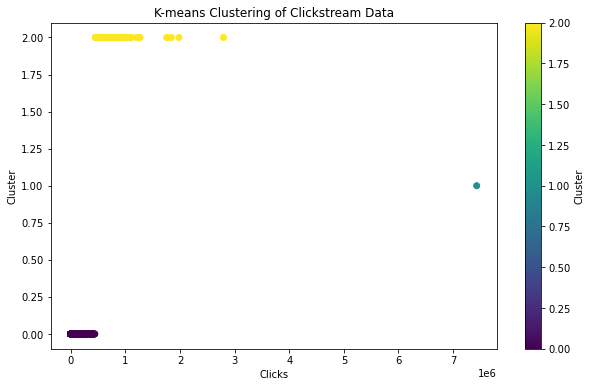

In [9]:
# Collect results for visualization
import pandas as pd
import matplotlib.pyplot as plt
results = predictions.select("clicks", "prediction").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(results["clicks"], results["prediction"], c=results["prediction"], cmap="viridis", marker='o')
plt.xlabel("Clicks")
plt.ylabel("Cluster")
plt.title("K-means Clustering of Clickstream Data")
plt.colorbar(label="Cluster")
plt.show()

# Stop the Spark session
spark.stop()

### Visualization Observations

**Clusters Distribution**: 
There are distinctly different clusters represented by different colors. The x-axis (clicks) reveals that:

The purple cluster contains data points with very few clicks, clustered near the origin.
The yellow clusters are higher on the click scale but still relatively low compared to others, showing moderate click activity.
The green dot represents an outlier with an extremely high number of clicks compared to other data points.

**Significance/Interpretation**:

The purple cluster likely represents items that are very infrequently clicked.
The yellow clusters may represent items with moderate popularity or engagement.
The single green point might be an extremely popular item or an anomaly due to its significantly higher clicks, suggesting it could be a popular article or a viral content piece.